# Importing Libraries

In [124]:
# importing required libraries
import warnings
warnings.filterwarnings('ignore')
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk
from nltk import ToktokTokenizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from bs4 import BeautifulSoup
import unicodedata
import re
import contractions
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

[nltk_data] Downloading package punkt to /Users/manjusri/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/manjusri/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/manjusri/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Load Dataset

In [125]:
# Load the Tweets.csv
tweets = pd.read_csv('Tweets.csv')
# Set max_colwidth so we can see the entire text
pd.set_option('display.max_colwidth', None)
# Displaying 5 rows
tweets.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials to the experience... tacky.,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I need to take another trip!,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing about it,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


### Insigths:

`The dataset has several columns. Some of the columns has NaN values. It seems we don't need all these columns to do
the sentiment analysis, for example tweet_created time, tweet_location doesn't impact the sentiment`

In [126]:
# Displaying the dataset shape
print(tweets.shape)

(14640, 15)


### Insigths:

`The dataset has 14640 tweets with 15 columns`

In [127]:
# data description
tweets.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,tweet_id,airline_sentiment_confidence,negativereason_confidence,retweet_count
count,14640.00000,14640.00000,10522.00000,14640.00000
mean,569218351767499200.00000,0.90017,0.63830,0.08265
std,779111158481835.87500,0.16283,0.33044,0.74578
min,567588278875213824.00000,0.33500,0.00000,0.00000
25%,568559178101439488.00000,0.69230,0.36060,0.00000
50%,569477857923110912.00000,1.00000,0.67060,0.00000
75%,569890473289000960.00000,1.00000,1.00000,0.00000
max,570310600460525568.00000,1.00000,1.00000,44.00000


# Understand of data columns

In [128]:
# Displaying the columns in the dataset
tweets.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

In [129]:
# Dropping all the columns except 'text' and 'airline_sentiment' and updating the tweets dataset using inplace=True
tweets.drop(tweets.columns.difference(['text', 'airline_sentiment']), axis=1, inplace=True)
# Displaying the shape of the dataset after removing other columns
tweets.shape

(14640, 2)

### Insigths:

`The dataset now has 14640 tweets with 2 columns`

In [130]:
# Displaying the 5 rows after removing the other columns data
tweets.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials to the experience... tacky.
2,neutral,@VirginAmerica I didn't today... Must mean I need to take another trip!
3,negative,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse"
4,negative,@VirginAmerica and it's a really big bad thing about it


### Insights:

`airline_sentiment column has the classes like negative, neutral and positive hence its our target column`

`The text column has text with special characters, html codes.. etc. we need to clean the text`

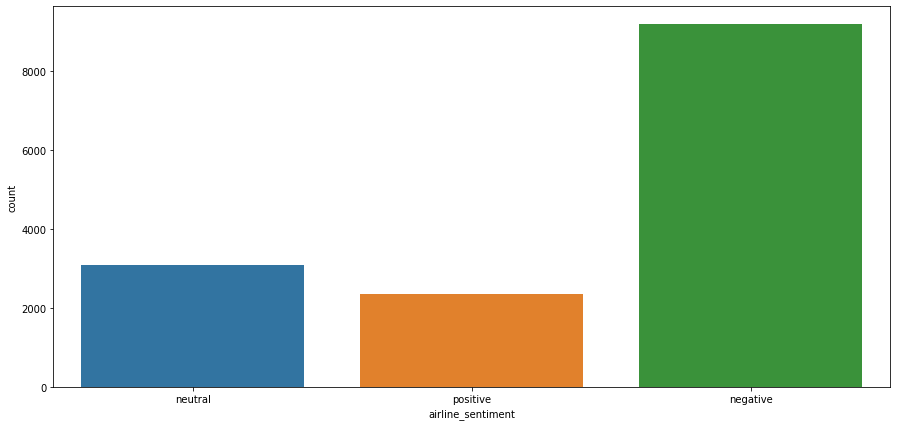

In [131]:
# Plotting count plot of airline_sentiment
plt.figure(figsize=(15,7))
sns.countplot(tweets['airline_sentiment'])
plt.show()

### Insights:

`The dataset has tweets with negative sentiment more`

# Text Pre-Processing

In [132]:
# Reading a sample tweet from the dataset so that we can verify the output of each preprocessing function
sample_tweet= tweets['text'][3]
sample_tweet

'@VirginAmerica it\'s really aggressive to blast obnoxious "entertainment" in your guests\' faces &amp; they have little recourse'

### Insigths:

`The text has special characters like @, " and has contractions (It's, guests'). It also has html code &amp;`

In [133]:
# Function to remove html tags in the text.
# The function uses BeautifulSoup to remove the html tags
def remove_html_tags(text):
    soup = BeautifulSoup(text, 'html.parser')
    return soup.get_text()

In [134]:
# Removing html tags from the sample tweet and updating it
sample_tweet = remove_html_tags(sample_tweet)
sample_tweet

'@VirginAmerica it\'s really aggressive to blast obnoxious "entertainment" in your guests\' faces & they have little recourse'

### Insigths:

`remove_html_tags removed the html code &amp; from sample tweet text`

In [135]:
# Function to create tokens from a given text. Uses ToktokTokenizer from nltk library
def tokenize(text):
    toktok = ToktokTokenizer()
    # Overridding toktok instance fields as the default one is converting & to amp. 
    # The following code overrides that behaviour
    toktok.AMPERCENT = re.compile('& '), '& '
    toktok.TOKTOK_REGEXES = [(regex, sub) if sub != '&amp; ' else (re.compile('& '), '& ') for (regex, sub) in
                            ToktokTokenizer.TOKTOK_REGEXES]

    tokens = toktok.tokenize(text)
    return [token.strip() for token in tokens]

In [136]:
# Tokenizing sample tweet and creating sample_tweet_tokens list
sample_tweet_tokens = tokenize(sample_tweet)
print(sample_tweet_tokens)

['@VirginAmerica', 'it', "'", 's', 'really', 'aggressive', 'to', 'blast', 'obnoxious', '"', 'entertainment', '"', 'in', 'your', 'guests', "'", 'faces', '&', 'they', 'have', 'little', 'recourse']


## Insigths:

`We can see it tokenized the entire sentense in to a list of words`

In [137]:
# Function to remove numbers, uses regular expression to replace numbers with empty string
def remove_numbers(tokens):
    return [re.sub(r'\d+', '', token) for token in tokens]

In [138]:
# Removing numbers if present in the sample tweet tokens
sample_tweet_tokens = remove_numbers(sample_tweet_tokens)
print(sample_tweet_tokens)

['@VirginAmerica', 'it', "'", 's', 'really', 'aggressive', 'to', 'blast', 'obnoxious', '"', 'entertainment', '"', 'in', 'your', 'guests', "'", 'faces', '&', 'they', 'have', 'little', 'recourse']


## Insigths:

`There is no change to the tokens list as there are no numbers present in the given list`

In [139]:
# Function to transform accented characters if any in to closest english characters
def transform_accented_chars(tokens):
    return [unicodedata.normalize('NFKD', token).encode('ascii', 'ignore').decode('utf-8', 'ignore') for token in tokens]

In [140]:
# Transforming accented characters if any in the sample tweet tokens array
sample_tweet_tokens = transform_accented_chars(sample_tweet_tokens)
print(sample_tweet_tokens)

['@VirginAmerica', 'it', "'", 's', 'really', 'aggressive', 'to', 'blast', 'obnoxious', '"', 'entertainment', '"', 'in', 'your', 'guests', "'", 'faces', '&', 'they', 'have', 'little', 'recourse']


## Insigths:

`There is no change to the tokens list as there are no accented characters`

In [141]:
# Function to remove special characters, uses regular expression to replace special characters with empty string
def remove_special_chars(tokens):
    return [re.sub(r'[^a-zA-z\s]', '', token) for token in tokens]

In [142]:
# Removing special characters from sample tweet tokens
sample_tweet_tokens = remove_special_chars(sample_tweet_tokens)
print(sample_tweet_tokens)

['VirginAmerica', 'it', '', 's', 'really', 'aggressive', 'to', 'blast', 'obnoxious', '', 'entertainment', '', 'in', 'your', 'guests', '', 'faces', '', 'they', 'have', 'little', 'recourse']


## Insigths:

`It replaced special characters with empty string. For instance @VirginAmerica is converted to VirginAmerica by removing the special character @`

In [143]:
# Function to remove punctuations, uses regular expression to remove punctuations 
def remove_punctuations(tokens):
    return [re.sub(r'[^\w\s]','', token) for token in tokens]

In [144]:
# Removing punctuations from sample tweet tokens list
sample_tweet_tokens = remove_punctuations(sample_tweet_tokens)
print(sample_tweet_tokens)

['VirginAmerica', 'it', '', 's', 'really', 'aggressive', 'to', 'blast', 'obnoxious', '', 'entertainment', '', 'in', 'your', 'guests', '', 'faces', '', 'they', 'have', 'little', 'recourse']


## Insigths:

`There is no change to the tokens list as there are no punctuations present in the list`

In [145]:
# Function to replace contractions, uses contractions library
def replace_contractions(tokens):
    return [contractions.fix(token) for token in tokens]

In [147]:
# Replacing contractions from sample tweet tokens list
sample_tweet_tokens = replace_contractions(sample_tweet_tokens)
print(sample_tweet_tokens)

['VirginAmerica', 'it', '', 's', 'really', 'aggressive', 'to', 'blast', 'obnoxious', '', 'entertainment', '', 'in', 'your', 'guests', '', 'faces', '', 'they', 'have', 'little', 'recourse']


## Insigths:

`There is no change to the tokens list as there are no contractions present in the list`

In [148]:
# Function to remove stopwords. 
def remove_stop_words(tokens):
    stop_words = nltk.corpus.stopwords.words('english')
    list_of_words_to_keep = ['not', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn',
        "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',
        "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn',
        "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]
    # Removing the above list of words the stop words list so that we can keep these words in the original tokens/text
    stop_words = list(set(stop_words) - set(list_of_words_to_keep))
    return [token for token in tokens if token not in stop_words]


In [149]:
# Removing stop words from sample tweet tokens list
sample_tweet_tokens = remove_stop_words(sample_tweet_tokens)
print(sample_tweet_tokens)

['VirginAmerica', '', 'really', 'aggressive', 'blast', 'obnoxious', '', 'entertainment', '', 'guests', '', 'faces', '', 'little', 'recourse']


## Insigths:

`The sample_tweet_tokens list is shrinked as we removed the stop words like it, s, to, in, your..etc from the list`

In [150]:
# Function to convert the text to lower case
def to_lower(tokens):
    return [token.lower() for token in tokens]

In [151]:
# converting the sample tweet tokens into lower case letters
sample_tweet_tokens = to_lower(sample_tweet_tokens)
print(sample_tweet_tokens)

['virginamerica', '', 'really', 'aggressive', 'blast', 'obnoxious', '', 'entertainment', '', 'guests', '', 'faces', '', 'little', 'recourse']


## Insigths:

`The tokens in sample_tweet_tokens list are now lowercase words.`

In [152]:
# Function to perform Lemmatization
def perform_lemmatization(tokens):
    lemmatizer = nltk.stem.WordNetLemmatizer()
    return [lemmatizer.lemmatize(token) for token in tokens]

In [153]:
# Lemmatizing the sample tweet tokens and joining the tokens to form a sentence. 
# While joining we eliminated tokens that are just spaces using filter function
sample_tweet_tokens = perform_lemmatization(sample_tweet_tokens)
' '.join(filter(None, sample_tweet_tokens))

'virginamerica really aggressive blast obnoxious entertainment guest face little recourse'

## Insigths:

`Lemmatization converted the tokens into base words. for example guests and faces are converted to guest and face respectively`

In [154]:
# A consolidated text preprocessing function which calls all the above pre processing functions for every text in the
# tweets dataframe.
def preprocess(df):
    tweets = df['text']
    # create an empty list to hold the pre-processed text
    preprocessed_text = []
    # loop through every tweet in the dataframe
    for tweet in tweets:
        # remove html tags from tweet
        tweet = remove_html_tags(tweet)
        # tokenize the tweet
        tokens = tokenize(tweet)
        # transform the accented characters
        tokens = transform_accented_chars(tokens)
        # remove numbers from tokens
        tokens = remove_numbers(tokens)
        # remove special characters from tokens
        tokens = remove_special_chars(tokens)
        # remove punctuations from tokens
        tokens = remove_punctuations(tokens)
        # replace contractions from tokens
        tokens = replace_contractions(tokens)
        # remove stopwords from tokens
        tokens = remove_stop_words(tokens)
        # convert tokens to lowercase
        tokens = to_lower(tokens)
        # perform lemmatization of tokens
        tokens = perform_lemmatization(tokens)
        # join the tokens to form the sentence back, filter the tokens that are just empty spaces
        text = ' '.join(filter(None,tokens))
        # add the pre processed or cleansed text to preprocessed_text list
        preprocessed_text.append(text)
    return preprocessed_text

In [155]:
# Invoking preprocess function to process all tweets
preprocessed_tweets = preprocess(tweets)
# Displaying first 5 tweets after pre processing
preprocessed_tweets[0:5]

['virginamerica what dhepburn said',
 'virginamerica plus added commercial experience tacky',
 'virginamerica i didn today must mean i need take another trip',
 'virginamerica really aggressive blast obnoxious entertainment guest face little recourse',
 'virginamerica really big bad thing']

##### Original tweet text
<p>@VirginAmerica What @dhepburn said.</p>
<p>@VirginAmerica plus you've added commercials to the experience... tacky.</p>
<p>@VirginAmerica I didn't today... Must mean I need to take another trip!</p>
<p>@VirginAmerica it's really aggressive to blast obnoxious "entertainment" in your guests' faces &amp; they have little recourse</p>
<p>@VirginAmerica and it's a really big bad thing about it</p>

##### Pre-processed tweet text
<p>virginamerica what dhepburn said</p>
<p>virginamerica plus added commercial experience tacky</p>
<p>virginamerica i didn today must mean i need take another trip</p>
<p>virginamerica really aggressive blast obnoxious entertainment guest face little recourse</p>
<p>virginamerica really big bad thing</p>

### Insights:
<ol>
    <li> The preprocessing removed special characters like <b>@, ..., ", " </b>..etc. It also removed html codes like <b>& amp;</b></li>
    <li> The preprocessing removed stop words like <b>It's, you've</b>..etc</li>
    <li> Data preprocessing removed punctuations like <b>'!'</b>.</li>
    <li> Proceprocessing converted every text into lowercase</li>
    <li> The preprocessing converted the words into root form by using lemmatization. For instance,  <b>guests faces </b>got converted to <b>guest face</b></li>
</ol>

# Vecrtorization

In [156]:
# Function to convert the text into numerical values using CountVectorizer
def count_vectorize(data):
    # instantiate CountVectorizer instance with max_features = 1000
    vectorizer = CountVectorizer(max_features=1000)
    # fit and transform the data
    vectorized_features = vectorizer.fit_transform(data)
    # convert the data to an array and return
    return vectorized_features.toarray()

In [157]:
# Function to convert the text into numerical values using TfidfVectorizer
def tfidf_vectorize(data):
    # instantiate TfidfVectorizer instance with max_features = 1000
    vectorizer = TfidfVectorizer(max_features=1000)
    # fit and transform the data
    vectorized_features = vectorizer.fit_transform(data)
    # convert the data to an array and return
    return vectorized_features.toarray()

In [158]:
# Converting preprocessed tweets into numerical values using CountVectorizer
count_vectorized_tweets = count_vectorize(preprocessed_tweets)
# Displaying the count vector
count_vectorized_tweets

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [159]:
# Displaying the shape after count vectorization
count_vectorized_tweets.shape

(14640, 1000)

### Insights:

`After count vectorization, we have 14640 rows with 1000 features`

In [160]:
# Displaying the first row
count_vectorized_tweets[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

### Insights:

`The count vector is a matrix of values 0 and 1 depending upon the word occurance`

In [161]:
# Converting preprocessed tweets in to numerical values using TfidfVectorizer
tfidf_vectorized_tweets = tfidf_vectorize(preprocessed_tweets)
# Displaying the tfidf vector
tfidf_vectorized_tweets

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [162]:
# Displaying the shape after tfidf vectorization
tfidf_vectorized_tweets.shape

(14640, 1000)

`After tfidf vectorization, we have 14640 rows with 1000 features`

In [163]:
# Displaying the first row
tfidf_vectorized_tweets[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

### Insights:


`The tfidf vector is a matrix of values between 0 and 1`

# Fit and Evalute Models

In [168]:
# Assigning airline_sentiment data to y as dependent variable
y = tweets['airline_sentiment']

In [169]:
# Converting y from text to numbers using LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
y

array([1, 2, 1, ..., 1, 0, 1])

In [170]:
# Creating a dataframe to display the text sentiment and the corresponding label encoder
sentiment_text_vs_label = pd.DataFrame(columns=['text', 'label'])
sentiment_text_vs_label['text'] = tweets['airline_sentiment'][0:5]
sentiment_text_vs_label['label'] = y[0:5]
sentiment_text_vs_label

,text,label
0,neutral,1
1,positive,2
2,neutral,1
3,negative,0
4,negative,0


### Insights:

`The labelencoder mapped the sentiments as below `
 <ol>
    <li>negative --> 0</li>
    <li>neutral --> 1</li>
    <li>positive --> 2</li>
 </ol>
    

In [171]:
# Function splits the given X and y data into X_train, X_val, X_test, y_train, y_val, y_test and returns them
def split(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)
    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.3, random_state=7)
    return X_train, X_val, X_test, y_train, y_val, y_test

In [172]:
# Function to construct list of machine learning classification models that we are going to evaluate.
def construct_models_list():
    models = [
        # Since its a multiclass problem using multi_class='multinomial', solver='lbfgs' for logistic regression
        {'model': LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=7), 'name': 'Logistic Regressor'},
        {'model': DecisionTreeClassifier(max_depth=7, random_state=7), 'name': 'DecisionTree Classifier'},
        {'model': RandomForestClassifier(n_estimators=100, 
                                         criterion='entropy',
                                         max_features='auto',
                                         max_depth=7, 
                                         n_jobs=4, 
                                         random_state=7), 'name': 'RandomForest Classifier'},
        {'model': GradientBoostingClassifier(n_estimators=100,
                                             criterion='mse',
                                             learning_rate=0.1,
                                             max_depth=4,
                                             random_state=7), 'name': 'GradientBoost Classifier'}
    ]
    
    return models

In [173]:
# Creating a dataframe to hold the train, validation and test accuracies of all the models that we evaluate
result_df = pd.DataFrame(columns=['train accuracy', 'k-fold-cv mean', 'k-fold-cv std', 'test_accuracy'])

# Function to evaluate each model against train, validation and test data by looping through all the models that 
# construct_models_list function returns. It uses K-Fold cross validation
def evaluate_models(xtrain, xval, ytrain, yval, xtest, ytest, model_name_prefix, result_df):
    start_time = time.process_time()
    kfold = KFold(n_splits=10, random_state=7, shuffle=True)
    # get the list of models to evaluate
    models = construct_models_list()
    # loop through each model
    for model_obj in models:
        # getting the model instance
        model = model_obj['model']
        name = model_name_prefix+'_'+model_obj['name']
        # fit the model against train data
        model.fit(xtrain, ytrain)
        # compute the train accuracy
        train_accuracy = model.score(xtrain, ytrain)
        # evaluate the model using K-Fold cross validation
        cv_result = cross_val_score(model, xval, yval, cv=kfold, n_jobs=4)
        # print the result of cross validation
        print(cv_result)
        # compute the test accuracy
        test_accuracy = model.score(xtest, ytest)
        # store train accuracy, cross validation results mean, standard deviation and test accuracy for each model name
        result_df.loc[name] = [train_accuracy, cv_result.mean(), cv_result.std(), test_accuracy]
        # return the result_df
    total_time_taken = time.process_time() - start_time
    # Logging the time taken for models evaluation, just for informational purpose
    print('\nTime taken to evaluate models with {} data {}'.format(model_name_prefix, total_time_taken))
    return result_df

## Using Count Vectorizer

In [174]:
# Split the count vectorized data into train, validation and test
X_train, X_val, X_test, y_train, y_val, y_test = split(count_vectorized_tweets,y)
# Print the shape of the data
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_val shape:', X_val.shape)
print('y_val shape:', y_val.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_train shape: (10248, 1000)
y_train shape: (10248,)
X_val shape: (1318, 1000)
y_val shape: (1318,)
X_test shape: (3074, 1000)
y_test shape: (3074,)


In [175]:
# Evaluating the models with CounterVectorized data and storing the results in result_df dataframe
result_df = evaluate_models(X_train, X_val, y_train, y_val, X_test, y_test, 'CountVectorizer', result_df)
# Displaying result_df dataframe
result_df

[0.81060606 0.75757576 0.75       0.70454545 0.77272727 0.66666667
 0.6969697  0.68939394 0.78625954 0.7480916 ]
[0.72727273 0.62878788 0.71969697 0.70454545 0.70454545 0.61363636
 0.64393939 0.62121212 0.70229008 0.67938931]
[0.67424242 0.60606061 0.62878788 0.65909091 0.66666667 0.57575758
 0.60606061 0.58333333 0.74045802 0.67175573]
[0.78787879 0.6969697  0.71969697 0.68181818 0.74242424 0.63636364
 0.65909091 0.66666667 0.77099237 0.7480916 ]

Time taken to evaluate models with CountVectorizer data 143.55333099999984


,train accuracy,k-fold-cv mean,k-fold-cv std,test_accuracy
CountVectorizer_Logistic Regressor,0.842799,0.738284,0.044372,0.781718
CountVectorizer_DecisionTree Classifier,0.693111,0.674532,0.041227,0.676643
CountVectorizer_RandomForest Classifier,0.624610,0.641221,0.048064,0.631100
CountVectorizer_GradientBoost Classifier,0.778884,0.710999,0.048195,0.736174


### Insights:

` Among all the models, logistic regression is giving better test accuracy of 78.1% for counter vectorized data`

In [176]:
# Creating logistic regression. Since its a multiclass problem using multi_class='multinomial', solver='lbfgs' for logistic regression
logit = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=7)
# Fitting the logistic regression with counter vectorized data
logit.fit(X_train, y_train)

LogisticRegression(multi_class='multinomial', random_state=7)

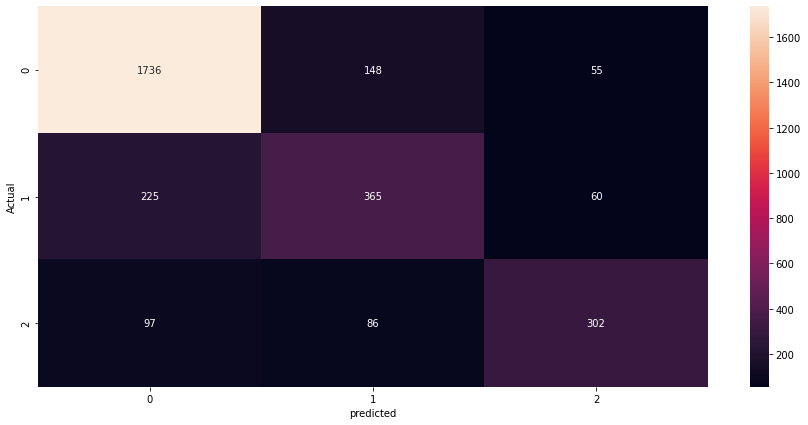

In [177]:
# Predicting for test data
y_predict = logit.predict(X_test)

# Creating confusion matrix using actual and predicted values
conf_matrix = confusion_matrix(y_test, y_predict)
# Creating a dataframe using confuxion matrix
conf_matrix_df = pd.DataFrame(conf_matrix, index=[0,1,2], columns=[0,1,2])
# Plotting confusion matrix in a heatmap
plt.figure(figsize=(15,7))
sns.heatmap(conf_matrix_df, annot=True, fmt='d')
plt.xlabel('predicted')
plt.ylabel('Actual')
plt.show()

In [178]:
# Printing the classification report
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1939
           1       0.61      0.56      0.58       650
           2       0.72      0.62      0.67       485

    accuracy                           0.78      3074
   macro avg       0.73      0.69      0.71      3074
weighted avg       0.78      0.78      0.78      3074



### Insights:

<ol>
    <li>The model has 84% precision and 90% recall for negative sentiments, 61% precision and 56% recall for neutral sentimants. Similarly 72% precision and 62% recall for postive sentiments </li>
    <li>The model overall accuracy is 78%</li>
</ol>

# Using TfIdf Vectorizer

In [180]:
# Split the tfidf vectorized data into train, validation and test
X_train, X_val, X_test, y_train, y_val, y_test = split(tfidf_vectorized_tweets,y)
# Print the shape of the data
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_val shape:', X_val.shape)
print('y_val shape:', y_val.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_train shape: (10248, 1000)
y_train shape: (10248,)
X_val shape: (1318, 1000)
y_val shape: (1318,)
X_test shape: (3074, 1000)
y_test shape: (3074,)


In [181]:
# Evaluating the models with Tfidfvectorized data and storing the results in result_df dataframe
result_df = evaluate_models(X_train, X_val, y_train, y_val, X_test, y_test, 'TfidfVectorizer', result_df)
# Displaying result_df dataframe
result_df

[0.78787879 0.71969697 0.72727273 0.72727273 0.75       0.68181818
 0.70454545 0.67424242 0.83206107 0.72519084]
[0.73484848 0.67424242 0.72727273 0.68939394 0.6969697  0.58333333
 0.6969697  0.62878788 0.73282443 0.70992366]
[0.67424242 0.60606061 0.62878788 0.65909091 0.66666667 0.57575758
 0.60606061 0.59090909 0.74045802 0.67938931]
[0.79545455 0.70454545 0.74242424 0.71212121 0.75757576 0.59848485
 0.67424242 0.64393939 0.79389313 0.73282443]

Time taken to evaluate models with TfidfVectorizer data 145.9685629999999


,train accuracy,k-fold-cv mean,k-fold-cv std,test_accuracy
CountVectorizer_Logistic Regressor,0.842799,0.738284,0.044372,0.781718
CountVectorizer_DecisionTree Classifier,0.693111,0.674532,0.041227,0.676643
CountVectorizer_RandomForest Classifier,0.624610,0.641221,0.048064,0.631100
CountVectorizer_GradientBoost Classifier,0.778884,0.710999,0.048195,0.736174
TfidfVectorizer_Logistic Regressor,0.828064,0.732998,0.045054,0.782368
TfidfVectorizer_DecisionTree Classifier,0.710870,0.687457,0.045867,0.680221
TfidfVectorizer_RandomForest Classifier,0.629098,0.642742,0.047731,0.636630
TfidfVectorizer_GradientBoost Classifier,0.793228,0.715551,0.059984,0.740403


### Insights:

` Among all the models, logistic regression is giving better test accuracy of 78.2% for tfidf vectorized data`

In [182]:
# Creating logistic regression, Since its a multiclass problem using multi_class='multinomial', solver='lbfgs' for logistic regression
logit = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=7)
# Fitting the logistic regression with tfidf vectorized data
logit.fit(X_train, y_train)

LogisticRegression(multi_class='multinomial', random_state=7)

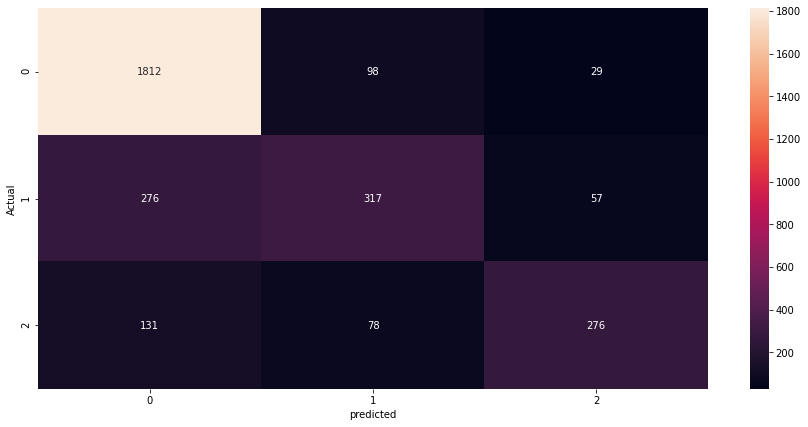

In [183]:
# Predicting for test data
y_predict = logit.predict(X_test)

# Creating confusion matrix using actual and predicted values
conf_matrix = confusion_matrix(y_test, y_predict)
# Creating a dataframe using confuxion matrix
conf_matrix_df = pd.DataFrame(conf_matrix, index=[0,1,2], columns=[0,1,2])
# Plotting confusion matrix in a heatmap
plt.figure(figsize=(15,7))
sns.heatmap(conf_matrix_df, annot=True, fmt='d')
plt.xlabel('predicted')
plt.ylabel('Actual')
plt.show()

In [184]:
# Printing the classification report
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.82      0.93      0.87      1939
           1       0.64      0.49      0.55       650
           2       0.76      0.57      0.65       485

    accuracy                           0.78      3074
   macro avg       0.74      0.66      0.69      3074
weighted avg       0.77      0.78      0.77      3074



### Insights:

<ol>
    <li>The model has 82% precision and 93% recall for negative sentiments, 64% precision and 49% recall for neutral sentimants. Similarly 76% precision and 57% recall for postive sentiments </li>
    <li>The model overall accuracy is 78%</li>
</ol>

# Summary

<ol>
    <li> We have used the tweets data that has the sentiment classified into negative, neutral and positive</li>
    <li> We have preprocessed the text by removing html tags, tokenized the text, removed accented characters, removed numbers, removed any special characters, removed punctuations, replaced contractions and stop words. We have converted the text into lower case and performed lemmatization of the tokens in a sentence and finally joined them to form the sentence back </li>
    <li> We did count vectorization and tfidf vectorization taking cleansed/preprocessed text as input. </li>
    <li> Count vectorized vector has values 0 and 1 where as tfidf vectorized matrix has float values between 0 and 1</li>
    <li> We fit both vectorized data against multiple machine learning classifier models. In both the cases, LogisticRegression seems performing well for the data.</li>
    <li> The test accuracy is almost the same with both tfidf and count vectorized data, with very minute increase when using tfidf vectorized data.</li>
</ol>